<a href="https://colab.research.google.com/github/fajrinovi/datacleansing-using-API/blob/main/Analyze_Characters_and_Words_Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import Library**

In [3]:
import numpy as np
import pandas as pd 
import os
import re
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import string
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
import os
import nltk
import spacy
from spacy.util import compounding
from spacy.util import minibatch
from sklearn.model_selection import train_test_split
import sqlite3

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## **Data Preparation**

In [4]:
conn = sqlite3.connect('datacleansing.db')

In [5]:
alay_dict = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Cleansing_data/new_kamusalay.csv', names = ['original', 'replacement'], encoding='latin-1')
abusive_dict = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Cleansing_data/abusive.csv', encoding='latin-1')
stopword_dict = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Cleansing_data/stopwordbahasa.csv', names = ['stopword'], encoding='latin-1')

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Cleansing_data/data.csv',encoding='latin-1')

In [7]:
df.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


**Mengecek total data dan jumlah kolom**

In [8]:
df.shape

(13169, 13)

**Mengecek total duplikat data**

In [9]:
df.duplicated().sum()

125

In [10]:
df = df.drop_duplicates()

**Mengecek missing values**

In [11]:
df.isna().sum()

Tweet            0
HS               0
Abusive          0
HS_Individual    0
HS_Group         0
HS_Religion      0
HS_Race          0
HS_Physical      0
HS_Gender        0
HS_Other         0
HS_Weak          0
HS_Moderate      0
HS_Strong        0
dtype: int64

**Data Cleaning**

In [58]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\\+n', ' ', text)
    text = re.sub('\n'," ",text) # Remove every '\n'
    
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('RT',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('USER', ' ', text)
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(':', ' ', text)
    text = re.sub(';', ' ', text)
    text = re.sub("'", " ", text)
    text = re.sub('\\+n', ' ', text)
    text = re.sub('\n'," ",text) # Remove every '\n'
    text = re.sub('\\+', ' ', text)
    text = re.sub('  +', ' ', text) # Remove extra spaces)
    return text
    
alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in str(text).split(' ')])

def remove_stopword(text):
    text = ' '.join(['' if word in stopword_dict.stopword.values else word for word in text.split(' ')])
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def remove_emoticon_byte(text):
    text = str(text).replace("\\", " ")
    text = re.sub('x..', ' ', text)
    text = re.sub(' n ', ' ', text)
    text = re.sub('\\+', ' ', text)
    text = re.sub('  +', ' ', text)
    return text

def remove_early_space(text):
    if text[0] == ' ':
        return text[1:]
    else:
        return text

In [59]:
def preprocess(text):
    text = lowercase(text)
    text = remove_unnecessary_char(text) # 2
    text = normalize_alay(text) # 3
    text = remove_unnecessary_char(text)
    text = remove_emoticon_byte(text)
    text = remove_early_space(text)
    text = remove_stopword(text)
    return text

def classify(hs):
    retval = ""
    if int(hs) == 1:
        retval = 'positive'
    else:
        retval = 'negative'
    return retval

**Membuat kolom total_char yang berisi panjang karakter tiap text dan total_word yang berisi banyak kata tiap text**

In [60]:
df['total_char'] = df['Tweet'].apply(len)

In [61]:
df['total_word'] = df['Tweet'].apply(lambda sent: len(sent.split()))

In [62]:
df.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,total_char,total_word,text,hs_class
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0,138,25,- cowok berusaha melacak perhatian gue. lantas...,positive
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0,120,21,telat tau elu?edan sarap gue bergaul ciga ifla...,negative
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0,254,37,"41. kadang berfikir, percaya tuhan jatuh berka...",negative
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0,75,14,nku tau matamu sipit aku',negative
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0,89,14,kaum cebong kafir dongoknya dungu hahahah',positive


In [63]:
df['text'] = df['Tweet'].apply(preprocess)
df['hs_class'] = df['HS'].apply(classify)
df[['text', 'hs_class']].sample(10)

,text,hs_class
6301,masak eh ajak ngentot sialan uniform resource ...,negative
7534,"diganti kotak kosong baik, dilan terpilih lagi...",positive
11471,"beda paham impor garam, menteri perdagangan ek...",negative
9630,"mohon blokir tegas,akun provokatif pemecah bel...",negative
7316,indahnya cocot pks. berbicara .ketum kayak ben...,positive
6970,am,negative
6041,antek komunis yayasan lembaga bantuan hukum in...,positive
2008,agama ..... ndi ka u tanda penduduk te ulis na...,negative
6467,deh elegan sampean undang penulis istana mengu...,positive
1005,rute pondok cina-gang sentiong keberangkatan p...,negative


In [64]:
train = df[['hs_class', 'text']]
base_train = train
train.to_csv('train_preprocessed.csv', index = False)
train.sample(5)

,hs_class,text
12341,positive,keren namanya gubernur indonesia. presiden kar...
6754,positive,rakyat paham hoaks nya golongan kampret..... r...
7114,positive,cebong dungu marah marah. ajaran nabi nya. ren...
8158,positive,anjir paypal anjing banget mengena fee nya
6540,negative,gus ipul-mbak puti berkomitmen meningkatkan pe...


## **Analyze**

### **Univariate Analysis**

**Mean**

Mencari rata-rata dari variabel(kolom) tang tipenya numerical

In [65]:
df.mean()

<ipython-input-65-c61f0c8f89b5>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.mean()


HS                 0.423030
Abusive            0.383701
HS_Individual      0.271389
HS_Group           0.151641
HS_Religion        0.060488
HS_Race            0.043162
HS_Physical        0.024686
HS_Gender          0.023306
HS_Other           0.284115
HS_Weak            0.256670
HS_Moderate        0.130175
HS_Strong          0.036185
total_char       114.124348
total_word        17.264259
dtype: float64

**Median**

Mencari nilai tengah dari data numerical yang diurutkan

In [66]:
df.median()

<ipython-input-66-6d467abf240d>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.median()


HS                 0.0
Abusive            0.0
HS_Individual      0.0
HS_Group           0.0
HS_Religion        0.0
HS_Race            0.0
HS_Physical        0.0
HS_Gender          0.0
HS_Other           0.0
HS_Weak            0.0
HS_Moderate        0.0
HS_Strong          0.0
total_char       100.0
total_word        15.0
dtype: float64

**Mode**

Mencari frekuensi data yang paling sering muncul

In [67]:
df['total_char'].mode()

0    254
dtype: int64

In [68]:
df['total_word'].mode()

0    11
dtype: int64

**Range**

Mencari perbedaan antara nilai terbesar dengan nilai terkecil pada data

In [69]:
range_total_word = df.total_word.max() - df.total_word.min()
range_total_word

51

In [70]:
range_total_char = df.total_char.max() - df.total_char.min()
range_total_char

557

**Quartile dan Interquartile Range**

In [71]:
#mencari nilai minimum
p0 = df.total_char.min()

#mencari nilai maximum
p100 = df.total_char.max()

# cari Q1
q1 = df.total_char.quantile(0.25)

#cari Q2
q2 = df.total_char.quantile(0.5)

#cari Q3
q3 = df.total_char.quantile(0.75)

#cari IQR
iqr = q3-q1

#cari batas bawah
lower_limit = q1-1.5*iqr

#cari batas atas
upper_limit = q3+1.5*iqr

print("Batas Bawah 'total_char' :", lower_limit)
print("Nilai minimum",p0)
if lower_limit < p0:
  print("Tidak ada outlier dari sisi batas bawah")
else:
  print("Ada outlier dari sisi batas bawah")

print()
print("Batas Atas 'total_char' :", upper_limit)
print("Nilai maksimum", p100)
if upper_limit > p100:
  print("Tidak ada outlier dari sisi batas atas")
else:
  print("Ada outlier dari sisi batas atas")

Batas Bawah 'total_char' : -80.5
Nilai minimum 4
Tidak ada outlier dari sisi batas bawah

Batas Atas 'total_char' : 291.5
Nilai maksimum 561
Ada outlier dari sisi batas atas


**Variance**

Mengukur seberapa jauh jarak data tersebar dari mean-nya. Kalau nilai variance suatu variabel/kolom lebih besar atau lebih kecil dari mean, maka nilai dari variabel/kolom itu menjauhi mean

In [72]:
df.var()

<ipython-input-72-28ded241fd7c>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.var()


HS                  0.244094
Abusive             0.236493
HS_Individual       0.197752
HS_Group            0.128656
HS_Religion         0.056833
HS_Race             0.041302
HS_Physical         0.024078
HS_Gender           0.022764
HS_Other            0.203409
HS_Weak             0.190805
HS_Moderate         0.113238
HS_Strong           0.034879
total_char       4775.035061
total_word        104.910534
dtype: float64



*   Nilai variance dari total_char sebesar 4775.035, sedangkan nilai mean total_char yaitu 114.124, maka nilai variance lebih dari nilai mean.
*   Nilai variance dari total_word sebesar 104.91, sedangkan nilai mean total_word yaitu 17.26, maka nilai variance lebih dari nilai mean.



**Standard Deviation**

Mengukur penyebaran observasi dalam kumpulan data relatif terhadap rata-ratanya

In [73]:
df.std()

<ipython-input-73-ce97bb7eaef8>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.std()


HS                0.494059
Abusive           0.486305
HS_Individual     0.444693
HS_Group          0.358686
HS_Religion       0.238397
HS_Race           0.203229
HS_Physical       0.155171
HS_Gender         0.150879
HS_Other          0.451009
HS_Weak           0.436812
HS_Moderate       0.336509
HS_Strong         0.186758
total_char       69.101629
total_word       10.242584
dtype: float64



*   Nilai standard deviation dari total_char sebesar 69.10, dan nilai mean total_char sebesar 114.12
*   Nilai standard deviation dari total_word sebesar 10.24, dan nilai mean total_word sebesar 17.26



**Skewness**

In [74]:
df.skew()

<ipython-input-74-9e0b1e29546f>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.skew()


HS               0.311631
Abusive          0.478368
HS_Individual    1.028331
HS_Group         1.942718
HS_Religion      3.687795
HS_Race          4.496498
HS_Physical      6.127256
HS_Gender        6.319885
HS_Other         0.957487
HS_Weak          1.114289
HS_Moderate      2.198351
HS_Strong        4.967777
total_char       0.693647
total_word       0.789820
dtype: float64

Nilai skewness di total_char yaitu 0.69 dan total_word yaitu 0.78, yang berarti nilai skewness kedua variabel/kolom lebih dari 0, sehingga bernilai positif

**Kurtosis**

In [75]:
df.kurtosis()

<ipython-input-75-c7edf97eb14c>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.kurtosis()


HS               -1.903178
Abusive          -1.771435
HS_Individual    -0.942681
HS_Group          1.774426
HS_Religion      11.601608
HS_Race          18.221291
HS_Physical      35.548712
HS_Gender        37.946761
HS_Other         -1.083385
HS_Weak          -0.758476
HS_Moderate       2.833181
HS_Strong        22.682291
total_char       -0.402291
total_word       -0.151707
dtype: float64

Nilai kurtosis total_char yaitu -0.4 dan total_word yaitu -0.15 yang bernilai kurang dari 3. Sehingga bersifat playkurtik yaitu cenderung menghasilkan lebih sedikit nilai outlier

**Pie Chart**

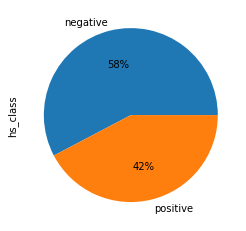

In [76]:
df.groupby('hs_class').hs_class.count().plot(kind='pie',autopct='%1.0f%%')

Dari pie chart bisa disimpulkan lebih banyak sentimen negatif

**Histogram**

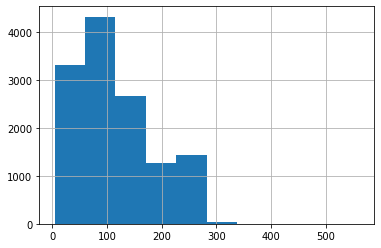

In [77]:
df.total_char.hist()

Rata-rata panjang karakter dari text adalah sekitar 60-110 karakter

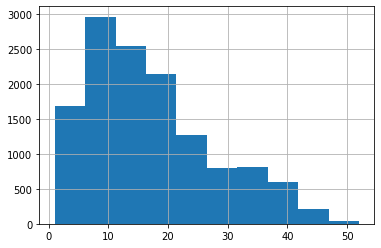

In [78]:
df.total_word.hist()

Rata-rata panjang kata dari text adalah sekitar 8-17 kata

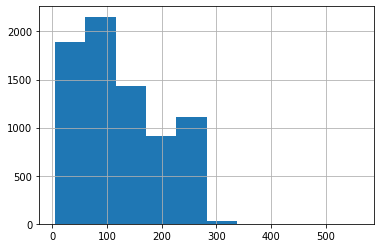

In [79]:
df_negative = df.loc[df['hs_class'] == 'negative']
df_negative.total_char.hist()

Pada sentimen negatif, panjang karakternya sekitar 10-110 karakter

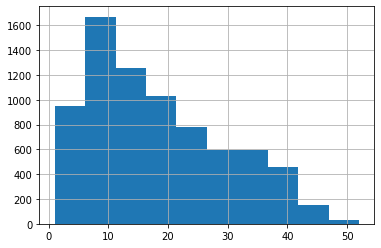

In [80]:
df_negative = df.loc[df['hs_class'] == 'negative']
df_negative.total_word.hist()

Pada sentimen negatif, panjang katanya sekitar 6-20 kata

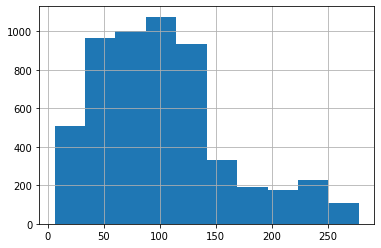

In [81]:
df_positive = df.loc[df['hs_class'] == 'positive']
df_positive.total_char.hist()

Panjang karakter pada sentimen positif sekitar 30-120 karakter

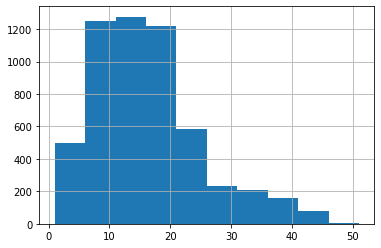

In [82]:
df_positive = df.loc[df['hs_class'] == 'positive']
df_positive.total_word.hist()

Panjang kata pada sentimen positif sekitar 6-21 kata

**Wordcloud**

In [83]:
train = df[['hs_class', 'text']]
train_pos = train[train['hs_class']=='positive']
train_neg = train[train['hs_class']=='negative']
train = pd.concat([train_pos, train_neg])
temp = train.groupby('hs_class').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Oranges')

,hs_class,text
0,negative,7526
1,positive,5518


In [84]:
train['temp_list'] = train['text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))

In [85]:
positive_text = train[train['hs_class']=='positive']
negative_text = train[train['hs_class']=='negative']

In [86]:
top = Counter([item for sublist in positive_text['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='YlOrBr')

,Common_words,count
0,indonesia,621
1,jokowi,577
2,resource,500
3,locator,500
4,uniform,499
5,orang,436
6,cebong,422
7,sih,398
8,ai,364
9,gue,346


In [89]:
top = Counter([item for sublist in negative_text['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Blues')

,Common_words,count
1,orang,718
2,presiden,595
3,indonesia,512
4,ya,466
5,daerah,364
6,agama,361
7,asing,355
8,i,324
9,sih,308
10,gubernur,307


<function matplotlib.pyplot.show(*args, **kw)>

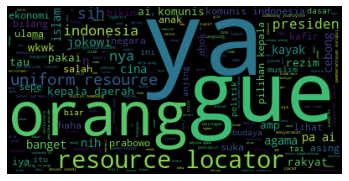

In [88]:
text = ' '.join(df['text'])
wordcloud = WordCloud().generate(text)

#Generate plot
plt.imshow(wordcloud)
plt.axis("off")
plt.show

### **Bivariate Analysis**

**Pearson Correlation**

In [ ]:
df.corr()

,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong,total_char,total_word
HS,1.000000,0.365292,0.712754,0.493752,0.296328,0.248039,0.185798,0.180403,0.735728,0.686258,0.451792,0.226287,-0.148112,-0.128527
Abusive,0.365292,1.000000,0.286353,0.148142,0.069610,-0.028722,0.196547,0.187413,0.261476,0.310169,0.188095,-0.098015,-0.211936,-0.193352
HS_Individual,0.712754,0.286353,1.000000,-0.258028,0.033899,-0.000672,0.214011,0.183402,0.636195,0.962826,-0.236100,0.058995,-0.140442,-0.119116
HS_Group,0.493752,0.148142,-0.258028,1.000000,0.366139,0.342486,-0.009406,0.021111,0.224657,-0.248436,0.915018,0.238550,-0.029893,-0.029356
HS_Religion,0.296328,0.069610,0.033899,0.366139,1.000000,0.094862,-0.003061,0.024751,-0.159848,0.033490,0.345290,0.083432,-0.004901,0.004380
HS_Race,0.248039,-0.028722,-0.000672,0.342486,0.094862,1.000000,-0.028927,-0.020306,-0.133800,-0.007345,0.238469,0.243672,-0.056811,-0.048205
HS_Physical,0.185798,0.196547,0.214011,-0.009406,-0.003061,-0.028927,1.000000,0.054019,-0.100225,0.220971,0.000123,-0.025535,-0.043631,-0.035267
HS_Gender,0.180403,0.187413,0.183402,0.021111,0.024751,-0.020306,0.054019,1.000000,-0.097315,0.190753,0.027826,-0.019047,-0.025737,-0.018621
HS_Other,0.735728,0.261476,0.636195,0.224657,-0.159848,-0.133800,-0.100225,-0.097315,1.000000,0.605078,0.225597,0.124610,-0.109286,-0.101147
HS_Weak,0.686258,0.310169,0.962826,-0.248436,0.033490,-0.007345,0.220971,0.190753,0.605078,1.000000,-0.227323,-0.113858,-0.131338,-0.108383


total_char memiliki nilai 1 dan total_word yaitu 0.95, yang berarti memiliki korelasi positif karena mendekati nilai 1

**Scatter**

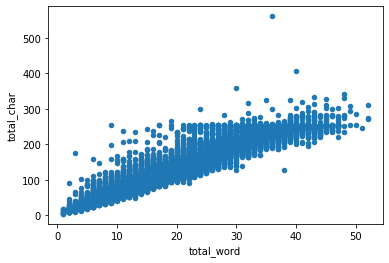

In [ ]:
df.plot(x='total_word', y='total_char', kind='scatter')

**Bar**

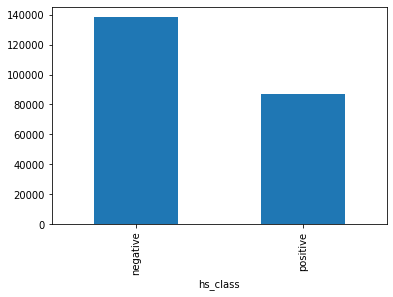

In [ ]:
df.groupby('hs_class').total_word.sum().plot(kind='bar')

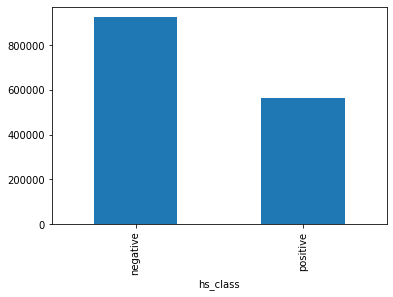

In [ ]:
df.groupby('hs_class').total_char.sum().plot(kind='bar')